### Импортирование необходимых библиотек

In [1]:
from typing import List, Optional
from tqdm import tqdm
import time

import math

from boruta import BorutaPy

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp, shapiro, ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency, ttest_rel, kurtosis
from statsmodels.stats.weightstats import zconfint

# импортирование библиотек моделей
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.metrics import roc_auc_score, r2_score, classification_report, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
%matplotlib inline

# убираем лишние замечания интерпретатора
import warnings
warnings.simplefilter('ignore')

# import additional packages for WOE/IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
# глобальные переменные WOE/IV
max_bin = 20
force_bin = 3

import gc
pd.options.display.max_columns = 50

### Полезные вункции для репортинга, балансировки и генерирования новых фич на основе фичей клиентского профиля

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
#    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
#    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [4]:
def create_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["EXT_SCOR_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["EXT_SCOR_EIGHTED"] = X.EXTERNAL_SCORING_RATING_1 * 2 + X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["ratio_annuity_to_salary"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['ratio_credit_to_salary'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    #X["total_salary_net"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]
    #X['ratio_credit_to_salary_net'] = X['AMOUNT_CREDIT'] / X['total_salary_net']

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["ratio_credit_to_age"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["ratio_salary_to_age"] = X["TOTAL_SALARY"] / X["AGE"]
    X["ratio_salary_to_experience"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_credit_to_experience"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_annuity_to_experience"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_salary_to_region_population"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["ratio_car_to_experience"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_car_to_age"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    #X["expected_total_loss"] = X["expected_total_loss_1"] * X["expected_total_loss_2"] * X["expected_total_loss_3"]
    X["expected_monthly_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]
    #X["expected_monthly_loss"] = X["expected_monthly_loss_1"] * X["expected_monthly_loss_2"] * X["expected_monthly_loss_3"]

    return X

### Загрузка датасетов

In [5]:
# dataset loading
train = pd.read_csv("/home/pi/GeekBrains/Kaggle/competition/train.csv")
test = pd.read_csv("/home/pi/GeekBrains/Kaggle/competition/test.csv")
client_profile = pd.read_csv("/home/pi/GeekBrains/Kaggle/competition/client_profile.csv")
bki = pd.read_csv("/home/pi/GeekBrains/Kaggle/competition/bki.csv")
payments = pd.read_csv("/home/pi/GeekBrains/Kaggle/competition/payments.csv")
applications = pd.read_csv("/home/pi/GeekBrains/Kaggle/competition/applications_history.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))
print("bki.shape = {} rows, {} cols".format(*bki.shape))
print("payments.shape = {} rows, {} cols".format(*payments.shape))
print("applications.shape = {} rows, {} cols".format(*applications.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols
client_profile.shape = 250000 rows, 24 cols
bki.shape = 945234 rows, 17 cols
payments.shape = 1023932 rows, 8 cols
applications.shape = 1670214 rows, 26 cols


In [6]:
X_train = train.copy()
X_test = test.copy()
X_client_profile = client_profile.copy()
X_bki = bki.copy()
X_payments = payments.copy()
X_applications = applications.copy()

X_train = X_train.sort_values(by = 'APPLICATION_NUMBER')
X_train = X_train.reset_index(drop=True)
X_bki = X_bki.sort_values(by = 'APPLICATION_NUMBER')
X_bki = X_bki.reset_index(drop=True)
X_client_profile = X_client_profile.sort_values(by = 'APPLICATION_NUMBER')
X_client_profile = X_client_profile.reset_index(drop=True)
X_payments = X_payments.sort_values(by = 'APPLICATION_NUMBER')
X_payments = X_payments.reset_index(drop=True)
X_applications = X_applications.sort_values(by = 'APPLICATION_NUMBER')
X_applications = X_applications.reset_index(drop=True)
X_test = X_test.sort_values(by = 'APPLICATION_NUMBER')
X_test = X_test.reset_index(drop=True)

print("APPLICATION_NUMBER_train = {} ".format(X_train['APPLICATION_NUMBER'].nunique()))
print("APPLICATION_NUMBER_test = {} ".format(X_test['APPLICATION_NUMBER'].nunique()))
print("APPLICATION_NUMBER_client_profile = {} ".format(X_client_profile['APPLICATION_NUMBER'].nunique()))
print("APPLICATION_NUMBER_bki = {} ".format(X_bki['APPLICATION_NUMBER'].nunique()))
print("APPLICATION_NUMBER_payments = {} ".format(X_payments['APPLICATION_NUMBER'].nunique()))
print("APPLICATION_NUMBER_applications = {} ".format(X_applications['APPLICATION_NUMBER'].nunique()))

APPLICATION_NUMBER_train = 110093 
APPLICATION_NUMBER_test = 165141 
APPLICATION_NUMBER_client_profile = 250000 
APPLICATION_NUMBER_bki = 273131 
APPLICATION_NUMBER_payments = 264726 
APPLICATION_NUMBER_applications = 338857 


### Разбиение датасетов для последующих слияниий с таблицами заявок, БКИ и платежей

X_train_cash = X_train.loc[X_train['NAME_CONTRACT_TYPE'] == 'Cash']
X_train_cc = X_train.loc[X_train['NAME_CONTRACT_TYPE'] != 'Cash']

X_test_cash = X_test.loc[X_test['NAME_CONTRACT_TYPE'] == 'Cash']
X_test_cc = X_test.loc[X_test['NAME_CONTRACT_TYPE'] != 'Cash']

### Слияние трейна и таблицы клиентского профиля

In [7]:
X_client_profile_ = create_profile_features(X_client_profile)
X_client_profile_.head(n=2)

X_train = pd.merge(train, X_client_profile_, how='outer')
X_train = X_train.sort_values(by = ['APPLICATION_NUMBER'])
X_train = X_train.reset_index(drop=True)
X_test = pd.merge(test, X_client_profile_, how='outer')
X_test = X_test.sort_values(by = ['APPLICATION_NUMBER'])
X_test = X_test.reset_index(drop=True)
X_train.shape

(270554, 52)

#### Замена отсутствующих значений в категориальных признаках на строку -999

In [8]:
X_train.loc[X_train['GENDER'].isna(), 'GENDER'] = 'zero'
X_test.loc[X_test['GENDER'].isna(), 'GENDER'] = 'zero'
X_train.loc[X_train['EDUCATION_LEVEL'].isna(), 'EDUCATION_LEVEL'] = 'zero'
X_test.loc[X_test['EDUCATION_LEVEL'].isna(), 'EDUCATION_LEVEL'] = 'zero'
X_train.loc[X_train['FAMILY_STATUS'].isna(), 'FAMILY_STATUS'] = 'zero'
X_test.loc[X_test['FAMILY_STATUS'].isna(), 'FAMILY_STATUS'] = 'zero'
X_train.shape

(270554, 52)

#### Выбор из всех датафреймов только тех строк, где значения в признаке NAME_CONTRACT_TYPE и создание трейна и цели

In [9]:
X_train = X_train.loc[~X_train['NAME_CONTRACT_TYPE'].isna()]
X_test = X_test.loc[~X_test['NAME_CONTRACT_TYPE'].isna()]
X_train.shape

(110093, 52)

#### Очистка трейна от выбросов

In [10]:
X_test.loc[X_test['TOTAL_SALARY'] > 100000000, 'TOTAL_SALARY'] = X_test['TOTAL_SALARY'].median()
X_test.loc[X_test['DAYS_ON_LAST_JOB'] > 360000, 'DAYS_ON_LAST_JOB'] = np.nan
X_train.loc[X_train['DAYS_ON_LAST_JOB'] > 360000, 'DAYS_ON_LAST_JOB'] = np.nan
X_train.loc[X_train['OWN_CAR_AGE'] >= 64, 'OWN_CAR_AGE'] = np.nan
X_test.loc[X_test['OWN_CAR_AGE'] >= 64, 'OWN_CAR_AGE'] = np.nan

#### Работа с дискретными признаками по уменьшению размерности на основе ЕДА

In [11]:
X_train.loc[(X_train['CHILDRENS'] == 0) | (X_train['CHILDRENS'] == 1)\
            | (X_train['CHILDRENS'] == 2), 'CHILDRENS'] = 1
X_train.loc[(X_train['FAMILY_SIZE'] == 4) | (X_train['FAMILY_SIZE'] == 1)\
            | (X_train['FAMILY_SIZE'] == 2) | (X_train['FAMILY_SIZE'] == 3),\
            'FAMILY_SIZE'] = 1
X_train.loc[(X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 0)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 4)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 1)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 2)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 3)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 5)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 6)\
            | (X_train['AMT_REQ_CREDIT_BUREAU_YEAR'] == 7),\
            'AMT_REQ_CREDIT_BUREAU_YEAR'] = 1

X_test.loc[(X_test['CHILDRENS'] == 0) | (X_test['CHILDRENS'] == 1)\
            | (X_test['CHILDRENS'] == 2), 'CHILDRENS'] = 1
X_test.loc[(X_test['FAMILY_SIZE'] == 4) | (X_test['FAMILY_SIZE'] == 1)\
            | (X_test['FAMILY_SIZE'] == 2) | (X_test['FAMILY_SIZE'] == 3),\
            'FAMILY_SIZE'] = 1
X_test.loc[(X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 0)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 4)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 1)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 2)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 3)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 5)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 6)\
            | (X_test['AMT_REQ_CREDIT_BUREAU_YEAR'] == 7),\
            'AMT_REQ_CREDIT_BUREAU_YEAR'] = 1

#### Кодирование категориальных признаков на основе частоты их появления в категориях

In [ ]:
freq_encoder = X_train["GENDER"].value_counts(normalize=True)
X_train["GENDER_FREQ_ENC"] = X_train["GENDER"].map(freq_encoder)
freq_encoder = X_train["EDUCATION_LEVEL"].value_counts(normalize=True)
X_train["EDUCATION_LEVEL_FREQ_ENC"] = X_train["EDUCATION_LEVEL"].map(freq_encoder)
freq_encoder = X_train["FAMILY_STATUS"].value_counts(normalize=True)
X_train["FAMILY_STATUS_FREQ_ENC"] = X_train["FAMILY_STATUS"].map(freq_encoder)
freq_encoder = X_train["NAME_CONTRACT_TYPE"].value_counts(normalize=True)
X_train["NAME_CONTRACT_TYPE_FREQ_ENC"] = X_train["NAME_CONTRACT_TYPE"].map(freq_encoder)

freq_encoder = X_test["GENDER"].value_counts(normalize=True)
X_test["GENDER_FREQ_ENC"] = X_test["GENDER"].map(freq_encoder)
freq_encoder = X_test["EDUCATION_LEVEL"].value_counts(normalize=True)
X_test["EDUCATION_LEVEL_FREQ_ENC"] = X_test["EDUCATION_LEVEL"].map(freq_encoder)
freq_encoder = X_test["FAMILY_STATUS"].value_counts(normalize=True)
X_test["FAMILY_STATUS_FREQ_ENC"] = X_test["FAMILY_STATUS"].map(freq_encoder)
freq_encoder = X_test["NAME_CONTRACT_TYPE"].value_counts(normalize=True)
X_test["NAME_CONTRACT_TYPE_FREQ_ENC"] = X_test["NAME_CONTRACT_TYPE"].map(freq_encoder)

#### Удаление малозначимых признаков на основе анализа важности признаков при обучениии на случайном лесе, корреляции между целью и признаками

In [12]:
X_train = X_train.drop(['FLAG_EMAIL','AMT_REQ_CREDIT_BUREAU_HOUR',
                        'AMT_REQ_CREDIT_BUREAU_WEEK','FAMILY_SIZE',
                        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_QRT'], axis=1)
X_test = X_test.drop(['FLAG_EMAIL','AMT_REQ_CREDIT_BUREAU_HOUR',
                        'AMT_REQ_CREDIT_BUREAU_WEEK','FAMILY_SIZE',
                        'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_DAY'], axis=1)

In [13]:
X_train_ = X_train.loc[X_train['GENDER'] != 'zero']
X_train_.shape

(89539, 46)

In [14]:
X_test1 = X_test.copy()
X_test2 = X_test.copy()
X_test1.shape

(165141, 46)

In [15]:
X_test2.shape

(165141, 46)

In [16]:
X_test1 = X_test1.loc[X_test1['GENDER'] != 'zero']
X_test1.shape

(134176, 46)

In [17]:
X_test2 = X_test2.loc[X_test2['GENDER'] == 'zero']
X_test2.shape

(30965, 46)

In [18]:
y_train = X_train['TARGET']
y_train_ = X_train_['TARGET']

X_train = X_train.drop(['APPLICATION_NUMBER','TARGET'], axis=1)
X_train_ = X_train_.drop(['APPLICATION_NUMBER','TARGET'], axis=1)

X_test1 = X_test1.drop(['APPLICATION_NUMBER'], axis=1)
X_test2 = X_test2.drop(['APPLICATION_NUMBER'], axis=1)

### Разбиение трейна на трейнн и тестт (70/30)

In [19]:
X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_train_, y_train_, shuffle=True, test_size=0.3, random_state=21)

### Балансировка целевой переменной по X_trainn<a class="anchor" id="target_balancing"></a>

df_for_balancing = pd.concat([X_trainn, y_trainn], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'TARGET')
    
df_balanced['TARGET'].value_counts()

X_trainn = df_balanced.drop(columns='TARGET')
y_trainn = df_balanced['TARGET']

### Обучение на лин регрессии и случайном лесе<a class="anchor" id="target_balancing"></a>

удаляем категориальные признаки

In [ ]:
X_train = X_train.drop(['GENDER','NAME_CONTRACT_TYPE','FAMILY_STATUS','EDUCATION_LEVEL'], axis=1)
X_test = X_test.drop(['GENDER','NAME_CONTRACT_TYPE','FAMILY_STATUS','EDUCATION_LEVEL'], axis=1)

X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_train, y_train, shuffle=True, test_size=0.3, random_state=21)

смотрим CV линейной регрессии

In [ ]:
features_train = X_train.columns.to_list()

estimator = LogisticRegression(random_state=27)
pipeline_std = Pipeline(
    steps=[("scaling", StandardScaler()), ("estimator", estimator)]
)

cv = cross_val_score(
    estimator=pipeline_std,
    X=X_train[features_train].fillna(0.4),
    y=y_train,
    scoring="roc_auc",
    cv=5,
)

print(f"CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

Обучаем модель на основе случайного леса, чтобы посмотреть важность фич

In [ ]:
features_train = X_train.columns.to_list()

model = RandomForestClassifier(min_samples_leaf=100, n_estimators=100, random_state=27)

model.fit(
    X_trainn[features_train].fillna(0),
    y_trainn
)

In [ ]:
print(roc_auc_score(y_trainn, model.predict_proba(X_trainn.fillna(0))[:,1]))
print(roc_auc_score(y_testt, model.predict_proba(X_testt.fillna(0))[:,1]))

#### Смотрим важность фич для отсеивания

In [ ]:
ntop = 60
importances = model.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(180,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### Обучение на CatBoost

### Выбор лучшей модели CatBoost и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [ ]:
categorical = ['NAME_CONTRACT_TYPE','GENDER','EDUCATION_LEVEL','FAMILY_STATUS']
model_catb = catb.CatBoostClassifier(cat_features=categorical, silent=True, random_state=21)

In [ ]:
params = {'n_estimators':[1400, 1500, 1600],
          'max_depth':[3, 4, 5]}

In [ ]:
cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='roc_auc', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

In [ ]:
rs.best_params_

In [ ]:
rs.best_score_

### Обучение фин модели на CatBoost

In [37]:
final_model = catb.CatBoostClassifier(cat_features=['NAME_CONTRACT_TYPE', 'GENDER',
                                                   'EDUCATION_LEVEL','FAMILY_STATUS'],
                                      n_estimators=1500, max_depth=4, silent=True,
                                      random_state=21)
final_model.fit(X_trainn, y_trainn)

print(roc_auc_score(y_trainn, final_model.predict_proba(X_trainn)[:,1]))
print(roc_auc_score(y_testt, final_model.predict_proba(X_testt)[:,1]))

0.8136891697630498
0.7615113823717368


Text(0.5, 1.0, 'What are the top important features to start with?')

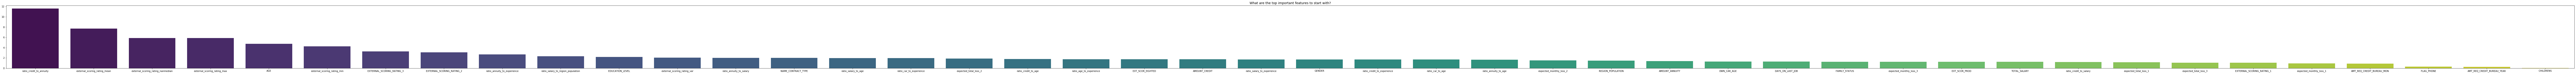

In [38]:
features_train = X_train.columns.to_list()
ntop = 80
importances = final_model.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(200,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [40]:
final_model.fit(X_train, y_train)

KeyboardInterrupt: 

### Подготовка файла для submission

In [22]:
TARGET = pd.DataFrame(final_model.predict_proba(X_test1)).drop(0, axis=1)
TARGET['idx'] = X_test1.index
TARGET.index = TARGET['idx']
TARGET = TARGET.rename(columns={'idx': 'Index'})
TARGET.head()

1  Index
idx                 
1    0.049825      1
2    0.041901      2
3    0.051236      3
5    0.097713      5
6    0.005383      6

In [23]:
final_model.fit(X_train, y_train)

In [24]:
TARGET_ = pd.DataFrame(final_model.predict_proba(X_test2)).drop(0, axis=1)
TARGET_['idx'] = X_test2.index
TARGET_.index = TARGET_['idx']
TARGET_ = TARGET_.rename(columns={'idx': 'Index'})
TARGET_.head()

1  Index
idx                 
19   0.060558     19
32   0.084450     32
34   0.084450     34
35   0.084450     35
39   0.084450     39

In [41]:
TARGET_.to_csv('TARGET_.csv')

In [25]:
TARGET_F = pd.merge(TARGET,TARGET_, how='outer')
TARGET_F = TARGET_F.sort_values(by = ['Index'])
TARGET_F = TARGET_F.reset_index(drop=True)
TARGET_F.head()

1  Index
0  0.049825      1
1  0.041901      2
2  0.051236      3
3  0.097713      5
4  0.005383      6

In [26]:
X_test_ = test.copy()
X_test_['TARGET'] = TARGET_F[1]
X_test_ = X_test_.drop(['NAME_CONTRACT_TYPE'], axis=1)
X_test_.head()

APPLICATION_NUMBER    TARGET
0           123724268  0.049825
1           123456549  0.041901
2           123428178  0.051236
3           123619984  0.097713
4           123671104  0.005383

In [27]:
X_test_.to_csv('test_submission.csv', index=False)

In [ ]:
model = lgbb.LIGHTG

### От Никиты

In [31]:
def catboost_cross_validation(params, X, y, cv, categorical='nan'):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def catboost_hold_out_validation(params, X, y, split_params = [0.7, 0.2, 0.1], categorical = None):
    """
    Hold-Out валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    split_params: List[float], optional, default = [0.7, 0.2, 0.1]
        Параметры (доли) разбиения выборки.
        Опциональный параметр, по умолчанию, равен [0.7, 0.2, 0.1].
    
    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimator: catboost.core.CatBoostClassifier
        Обученный классификатор catboost.

    test_prediction: np.array, optional
        Вектор прогнозов для тестовой выборки.
        Опциональный объект, возвращается только, если split_params
        содержит 3 значения.

    """
    numeric = list(set(X_train.columns) - set(categorical))
    x_train, x_valid = train_test_split(
        X, train_size=split_params[0], random_state=27
    )
    y_train, y_valid = train_test_split(
        y, train_size=split_params[0], random_state=27
    )

    if len(split_params) == 3:
        test_size = int(split_params[2] * X.shape[0])

        x_valid, x_test = train_test_split(
            x_valid, test_size=test_size, random_state=72
        )
        y_valid, y_test = train_test_split(
            y_valid, test_size=test_size, random_state=72
        )

    model = catb.CatBoostClassifier(**params)
    model.fit(
        x_train, y_train, categorical,
        eval_set=[(x_train, y_train), (x_valid, y_valid)]
    )

    print("="*65)
    valid_score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    print(f"Valid Score = {round(valid_score, 4)}")

    if len(split_params) == 3:

        test_prediction = model.predict_proba(x_test)[:, 1]
        test_score = roc_auc_score(y_test, test_prediction)
        print(f"Test Score = {round(test_score, 4)}")

        return model, test_prediction

    else:
        return model

In [28]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
X_train.head()

NAME_CONTRACT_TYPE GENDER  CHILDRENS  TOTAL_SALARY  AMOUNT_CREDIT  \
0                Cash      M        1.0    202500.000       406597.5   
4                Cash      M        1.0    121500.000       513000.0   
8                Cash   zero        0.0         0.000            0.0   
10               Cash      F        1.0    112500.000       652500.0   
11               Cash      F        1.0     38419.155       148365.0   

    AMOUNT_ANNUITY                EDUCATION_LEVEL         FAMILY_STATUS  \
0          24700.5  Secondary / secondary special  Single / not married   
4          21865.5  Secondary / secondary special  Single / not married   
8              0.0                           zero                  zero   
10         21177.0               Higher education               Married   
11         10678.5  Secondary / secondary special               Married   

    REGION_POPULATION      AGE  DAYS_ON_LAST_JOB  OWN_CAR_AGE  FLAG_PHONE  \
0            0.018801   9461.0             637.0          0.0         1.0   
4            0.028663  19932.0            3038.0          0.0         0.0   
8            0.000000      0.0               0.0          0.0         0.0   
10           0.022800  10197.0             679.0          0.0         0.0   
11           0.015221  20417.0               0.0          0.0         1.0   

    EXTERNAL_SCORING_RATING_1  EXTERNAL_SCORING_RATING_2  \
0                    0.083037                   0.262949   
4                    0.000000                   0.322738   
8                    0.000000                   0.000000   
10                   0.319760                   0.651862   
11                   0.722044                   0.555183   

    EXTERNAL_SCORING_RATING_3  AMT_REQ_CREDIT_BUREAU_MON  \
0                    0.139376                        0.0   
4                    0.000000                        0.0   
8                    0.000000                        0.0   
10                   0.363945                        1.0   
11                   0.652897                        0.0   

    AMT_REQ_CREDIT_BUREAU_YEAR  EXT_SCOR_PROD  EXT_SCOR_EIGHTED  \
0                          1.0       0.003043          0.847150   
4                          1.0       0.000000          0.000000   
8                          0.0       0.000000          0.000000   
10                         1.0       0.075861          2.383218   
11                         1.0       0.261725          3.957962   

    external_scoring_rating_min  external_scoring_rating_max  \
0                      0.083037                     0.262949   
4                      0.322738                     0.322738   
8                      0.000000                     0.000000   
10                     0.319760                     0.651862   
11                     0.555183                     0.722044   

    external_scoring_rating_mean  external_scoring_rating_nanmedian  \
0                       0.161787                           0.139376   
4                       0.322738                           0.322738   
8                       0.000000                           0.000000   
10                      0.445189                           0.363945   
11                      0.643375                           0.652897   

    external_scoring_rating_var  ratio_credit_to_annuity  \
0                      0.005646                16.461104   
4                      0.000000                23.461618   
8                      0.000000                 0.000000   
10                     0.021682                30.811730   
11                     0.004686                13.893805   

    ratio_annuity_to_salary  ratio_credit_to_salary  ratio_annuity_to_age  \
0                  0.121978                2.007889              2.610771   
4                  0.179963                4.222222              1.097005   
8                  0.000000                0.000000              0.000000   
10                 0.188240                5.80000

In [29]:
categorical = X_train.dtypes[X_train.dtypes == "object"].index.to_list()
X_train[categorical] = X_train[categorical].astype(str)
X_test[categorical] = X_test[categorical].astype(str)

In [30]:
cb_params = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 10,
    "max_depth": 4,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 4,
    "random_seed": 42
}

cv = StratifiedKFold(n_splits=5, random_state=27, shuffle=True)

estimators, valid_prediction = catboost_hold_out_validation(
    params=cb_params, X=X_train, y=y_train, categorical=categorical
)

NameError: name 'catboost_hold_out_validation' is not defined

In [32]:
numerical = list(set(X_train.columns) - set(categorical))
X_train[numerical] = X_train[numerical].astype(float)

In [33]:
X_train = X_train.drop(['APPLICATION_NUMBER'], axis=1)
X_test = X_test.drop(['APPLICATION_NUMBER'], axis=1)

KeyError: "['APPLICATION_NUMBER'] not found in axis"

In [34]:
X_train.head()

NAME_CONTRACT_TYPE GENDER  CHILDRENS  TOTAL_SALARY  AMOUNT_CREDIT  \
0                Cash      M        1.0    202500.000       406597.5   
4                Cash      M        1.0    121500.000       513000.0   
8                Cash   zero        0.0         0.000            0.0   
10               Cash      F        1.0    112500.000       652500.0   
11               Cash      F        1.0     38419.155       148365.0   

    AMOUNT_ANNUITY                EDUCATION_LEVEL         FAMILY_STATUS  \
0          24700.5  Secondary / secondary special  Single / not married   
4          21865.5  Secondary / secondary special  Single / not married   
8              0.0                           zero                  zero   
10         21177.0               Higher education               Married   
11         10678.5  Secondary / secondary special               Married   

    REGION_POPULATION      AGE  DAYS_ON_LAST_JOB  OWN_CAR_AGE  FLAG_PHONE  \
0            0.018801   9461.0             637.0          0.0         1.0   
4            0.028663  19932.0            3038.0          0.0         0.0   
8            0.000000      0.0               0.0          0.0         0.0   
10           0.022800  10197.0             679.0          0.0         0.0   
11           0.015221  20417.0               0.0          0.0         1.0   

    EXTERNAL_SCORING_RATING_1  EXTERNAL_SCORING_RATING_2  \
0                    0.083037                   0.262949   
4                    0.000000                   0.322738   
8                    0.000000                   0.000000   
10                   0.319760                   0.651862   
11                   0.722044                   0.555183   

    EXTERNAL_SCORING_RATING_3  AMT_REQ_CREDIT_BUREAU_MON  \
0                    0.139376                        0.0   
4                    0.000000                        0.0   
8                    0.000000                        0.0   
10                   0.363945                        1.0   
11                   0.652897                        0.0   

    AMT_REQ_CREDIT_BUREAU_YEAR  EXT_SCOR_PROD  EXT_SCOR_EIGHTED  \
0                          1.0       0.003043          0.847150   
4                          1.0       0.000000          0.000000   
8                          0.0       0.000000          0.000000   
10                         1.0       0.075861          2.383218   
11                         1.0       0.261725          3.957962   

    external_scoring_rating_min  external_scoring_rating_max  \
0                      0.083037                     0.262949   
4                      0.322738                     0.322738   
8                      0.000000                     0.000000   
10                     0.319760                     0.651862   
11                     0.555183                     0.722044   

    external_scoring_rating_mean  external_scoring_rating_nanmedian  \
0                       0.161787                           0.139376   
4                       0.322738                           0.322738   
8                       0.000000                           0.000000   
10                      0.445189                           0.363945   
11                      0.643375                           0.652897   

    external_scoring_rating_var  ratio_credit_to_annuity  \
0                      0.005646                16.461104   
4                      0.000000                23.461618   
8                      0.000000                 0.000000   
10                     0.021682                30.811730   
11                     0.004686                13.893805   

    ratio_annuity_to_salary  ratio_credit_to_salary  ratio_annuity_to_age  \
0                  0.121978                2.007889              2.610771   
4                  0.179963                4.222222              1.097005   
8                  0.000000                0.000000              0.000000   
10                 0.188240                5.80000

In [36]:
cb_params = {
    "n_estimators": 1500,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    #"max_bin": 20,
    "verbose": 10,
    "max_depth": 4,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 4,
    "random_seed": 42
}

cv = StratifiedKFold(n_splits=5, random_state=27, shuffle=True)

estimators, valid_prediction = catboost_cross_validation(
    params=cb_params, X=X_train_, y=y_train_, cv=cv, categorical=categorical
)

Sat Oct  3 00:23:33 2020, Cross-Validation, 89539 rows, 44 cols


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=0]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

### Adversarial Validation

In [ ]:
X_adv = pd.concat([
    X_train, X_test_
])

y_adv = np.hstack(
    (np.ones(X_train.shape[0]), np.zeros(X_test_.shape[0])))
X_adv = X_adv.reset_index(drop=True)

In [ ]:
%%time


model = catb.CatBoostClassifier(cat_features=['NAME_CONTRACT_TYPE', 'GENDER',
                                                   'EDUCATION_LEVEL','FAMILY_STATUS'],
                                     max_depth=3, silent=True,
                                      random_state=21)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=30)

plt.figure(figsize=(100, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

## Генерация новых фич

### Из application_history

In [ ]:
apps_fetures = X_applications.columns.to_list()
print(len(apps_fetures))

In [ ]:
apps_categorical_features = X_applications.select_dtypes(include=['object'])
print(f"count of categorical_features {apps_categorical_features.shape[1]}")
cat_features = apps_categorical_features.columns.to_list()
cat_features

In [ ]:
apps_numerical_features = X_applications.select_dtypes(exclude=['object']).columns.to_list()
print(f"count of numeric_features {len(apps_numerical_features)}")
apps_numerical_features

In [ ]:
apps_discrete_feature = [
    feature for feature in apps_numerical_features
    if len(X_applications[feature].unique())<25
]
print(f"Discrete Variables Count: {apps_discrete_feature}")

freq_encoder = X_applications["NAME_CONTRACT_TYPE"].value_counts(normalize=True)
X_applications["NAME_CONTRACT_TYPE_APP_FREQ_ENC"] = X_applications["NAME_CONTRACT_TYPE"].map(freq_encoder)
freq_encoder = X_applications["NAME_CONTRACT_STATUS"].value_counts(normalize=True)
X_applications["NAME_CONTRACT_STATUS_FREQ_ENC"] = X_applications["NAME_CONTRACT_STATUS"].map(freq_encoder)
freq_encoder = X_applications["NAME_PAYMENT_TYPE"].value_counts(normalize=True)
X_applications["NAME_PAYMENT_TYPE_FREQ_ENC"] = X_applications["NAME_PAYMENT_TYPE"].map(freq_encoder)
freq_encoder = X_applications["CODE_REJECT_REASON"].value_counts(normalize=True)
X_applications["CODE_REJECT_REASON_FREQ_ENC"] = X_applications["CODE_REJECT_REASON"].map(freq_encoder)
freq_encoder = X_applications["NAME_TYPE_SUITE"].value_counts(normalize=True)
X_applications["NAME_TYPE_SUITE_FREQ_ENC"] = X_applications["NAME_TYPE_SUITE"].map(freq_encoder)
freq_encoder = X_applications["NAME_CLIENT_TYPE"].value_counts(normalize=True)
X_applications["NAME_CLIENT_TYPE_FREQ_ENC"] = X_applications["NAME_CLIENT_TYPE"].map(freq_encoder)
freq_encoder = X_applications["NAME_GOODS_CATEGORY"].value_counts(normalize=True)
X_applications["NAME_GOODS_CATEGORY_FREQ_ENC"] = X_applications["NAME_GOODS_CATEGORY"].map(freq_encoder)
freq_encoder = X_applications["NAME_PRODUCT_TYPE"].value_counts(normalize=True)
X_applications["NAME_PRODUCT_TYPE_FREQ_ENC"] = X_applications["NAME_PRODUCT_TYPE"].map(freq_encoder)
freq_encoder = X_applications["NAME_YIELD_GROUP"].value_counts(normalize=True)
X_applications["NAME_YIELD_GROUP_FREQ_ENC"] = X_applications["NAME_YIELD_GROUP"].map(freq_encoder)
freq_encoder = X_applications["NAME_PORTFOLIO"].value_counts(normalize=True)
X_applications["NAME_PORTFOLIO_FREQ_ENC"] = X_applications["NAME_PORTFOLIO"].map(freq_encoder)

f = ['NAME_PORTFOLIO_FREQ_ENC','NAME_YIELD_GROUP_FREQ_ENC','NAME_PRODUCT_TYPE_FREQ_ENC',
 'NAME_GOODS_CATEGORY_FREQ_ENC','NAME_CLIENT_TYPE_FREQ_ENC','NAME_TYPE_SUITE_FREQ_ENC',
 'CODE_REJECT_REASON_FREQ_ENC','NAME_PAYMENT_TYPE_FREQ_ENC','NAME_CONTRACT_STATUS_FREQ_ENC',
 'NAME_CONTRACT_TYPE_APP_FREQ_ENC']

In [ ]:
X_applications_cash = X_applications[X_applications['NAME_CONTRACT_TYPE'] == 'Cash']
X_applications_cc = X_applications[X_applications['NAME_CONTRACT_TYPE'] != 'Cash']

#### по признакам на основе min()

In [ ]:
features = ['PREV_APPLICATION_NUMBER','AMOUNT_ANNUITY','AMT_APPLICATION','AMOUNT_CREDIT',
 'AMOUNT_PAYMENT','AMOUNT_GOODS_PAYMENT','DAYS_DECISION','SELLERPLACE_AREA','CNT_PAYMENT',
 'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE',
 'DAYS_TERMINATION','NFLAG_INSURED_ON_APPROVAL']

for num, feature in enumerate(features):
    num = X_applications.groupby('APPLICATION_NUMBER', as_index=False)
    num = num[''+feature+''].min()
    num = num.rename(columns={''+feature+'': ''+feature+'_MIN'+''})
    X_train = X_train_cash.merge(num, how="left", on="APPLICATION_NUMBER")
    X_test = X_test_cash.merge(num, how="left", on="APPLICATION_NUMBER")

for num, feature in enumerate(features):
    num = X_applications_cc.groupby('APPLICATION_NUMBER', as_index=False)
    num = num[''+feature+''].min()
    num = num.rename(columns={''+feature+'': ''+feature+'_MIN'+''})
    X_train_cc = X_train_cc.merge(num, how="left", on="APPLICATION_NUMBER")
    X_test_cc = X_test_cc.merge(num, how="left", on="APPLICATION_NUMBER")

In [ ]:
X_train = pd.concat([X_train_cash, X_train_cc], ignore_index=True)
X_train = X_train.sort_values(by = 'APPLICATION_NUMBER')
X_train = X_train.reset_index(drop=True)

X_test_ = pd.concat([X_test_cash, X_test_cc], ignore_index=True)
X_test_ = X_test_.sort_values(by = 'APPLICATION_NUMBER')
X_test_ = X_test_.reset_index(drop=True)

In [ ]:
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','NAME_CONTRACT_TYPE','APPLICATION_NUMBER'], axis=1)
X_test_ = X_test_.drop(['NAME_CONTRACT_TYPE','APPLICATION_NUMBER'], axis=1)
X_train.shape

In [ ]:
X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_train, y_train, shuffle=True, test_size=0.3, random_state=21)

In [ ]:
features_train = X_train.columns.to_list()


params = {
    "min_samples_leaf": [50]
}
model = RandomForestClassifier(n_estimators=50,random_state=27)
grid = GridSearchCV(
    model,
    param_grid=params,
    verbose=False,
    scoring=make_scorer(roc_auc_score),
    cv=5,
)

grid.fit(
    X_trainn[features_train].fillna(0),
    y_trainn
)

In [ ]:
print(roc_auc_score(y_trainn, grid.best_estimator_.predict_proba(X_trainn[features_train].fillna(0))[:,1]))
print(roc_auc_score(y_testt, grid.best_estimator_.predict_proba(X_testt[features_train].fillna(0))[:,1]))

In [ ]:
ntop = 60
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(90,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [ ]:
X_train_ = X_train.drop(['AMT_APPLICATION_MIN','AMOUNT_CREDIT_MIN',
 'AMOUNT_PAYMENT_MIN','SELLERPLACE_AREA_MIN','CNT_PAYMENT_MIN',
 'DAYS_FIRST_DRAWING_MIN','DAYS_FIRST_DUE_MIN','DAYS_LAST_DUE_MIN',
 'DAYS_TERMINATION_MIN','NFLAG_INSURED_ON_APPROVAL_MIN'], axis=1)

In [ ]:
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','APPLICATION_NUMBER'], axis=1)
X_test_ = X_test_.drop(['APPLICATION_NUMBER'], axis=1)

X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_train, y_train, shuffle=True, test_size=0.3, random_state=21)

In [ ]:
model_catb = catb.CatBoostClassifier(cat_features=['NAME_CONTRACT_TYPE'],
                                     silent=True, random_state=21)
model_catb.fit(X_trainn, y_trainn)

y_train_pred = model_catb.predict(X_trainn)
y_test_pred = model_catb.predict(X_testt)

get_classification_report(y_trainn, y_train_pred, y_testt, y_test_pred)

In [ ]:
print(roc_auc_score(y_trainn, model_catb.predict_proba(X_trainn)[:,1]))
print(roc_auc_score(y_testt, model_catb.predict_proba(X_testt)[:,1]))

In [ ]:
model_catb.fit(X_train, y_train)

### Из bki

In [ ]:
bki_fetures = X_bki.columns.to_list()
print(len(bki_fetures))

In [ ]:
bki_categorical_features = X_bki.select_dtypes(include=['object'])
print(f"count of categorical_features {bki_categorical_features.shape[1]}")
cat_features = bki_categorical_features.columns.to_list()
cat_features

In [ ]:
bki_numerical_features = X_bki.select_dtypes(exclude=['object']).columns.to_list()
print(f"count of numeric_features {len(bki_numerical_features)}")
bki_numerical_features

In [ ]:
bki_discrete_feature = [
    feature for feature in bki_numerical_features
    if len(X_bki[feature].unique())<25
]
print(f"Discrete Variables Count: {bki_discrete_feature}")

In [ ]:
freq_encoder = X_bki["CREDIT_ACTIVE"].value_counts(normalize=True)
X_bki["CREDIT_ACTIVE_FREQ_ENC"] = X_bki["CREDIT_ACTIVE"].map(freq_encoder)
freq_encoder = X_bki["CREDIT_CURRENCY"].value_counts(normalize=True)
X_bki["CREDIT_CURRENCY_FREQ_ENC"] = X_bki["CREDIT_CURRENCY"].map(freq_encoder)
freq_encoder = X_applications["NAME_PORTFOLIO"].value_counts(normalize=True)
X_bki["CREDIT_TYPE_FREQ_ENC"] = X_bki["CREDIT_TYPE"].map(freq_encoder)

In [ ]:
X_bki_cash = X_bki.loc[X_bki['CREDIT_TYPE'] != 'Credit card']
X_bki_cc = X_bki.loc[X_bki['CREDIT_TYPE'] == 'Credit card']

In [ ]:
features = ['BUREAU_ID','DAYS_CREDIT','CREDIT_DAY_OVERDUE','DAYS_CREDIT_ENDDATE',
             'DAYS_ENDDATE_FACT','AMT_CREDIT_MAX_OVERDUE','CNT_CREDIT_PROLONG',
             'AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT',
             'AMT_CREDIT_SUM_OVERDUE','DAYS_CREDIT_UPDATE','AMT_ANNUITY',
           'CREDIT_ACTIVE_FREQ_ENC','CREDIT_CURRENCY_FREQ_ENC','CREDIT_TYPE_FREQ_ENC']

for num, feature in enumerate(features):
    num = X_bki_cash.groupby('APPLICATION_NUMBER', as_index=False)
    num = num[''+feature+''].min()
    num = num.rename(columns={''+feature+'': ''+feature+'_MIN'+''})
    X_train_cash = X_train_cash.merge(num, how="left", on="APPLICATION_NUMBER")
    X_test_cash = X_test_cash.merge(num, how="left", on="APPLICATION_NUMBER")

for num, feature in enumerate(features):
    num = X_bki_cash.groupby('APPLICATION_NUMBER', as_index=False)
    num = num[''+feature+''].min()
    num = num.rename(columns={''+feature+'': ''+feature+'_MIN'+''})
    X_train_cc = X_train_cc.merge(num, how="left", on="APPLICATION_NUMBER")
    X_test_cc = X_test_cc.merge(num, how="left", on="APPLICATION_NUMBER")

In [ ]:
X_train = pd.concat([X_train_cash, X_train_cc], ignore_index=True)
X_train = X_train.sort_values(by = 'APPLICATION_NUMBER')
X_train = X_train.reset_index(drop=True)

X_test_ = pd.concat([X_test_cash, X_test_cc], ignore_index=True)
X_test_ = X_test_.sort_values(by = 'APPLICATION_NUMBER')
X_test_ = X_test_.reset_index(drop=True)

In [ ]:
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','APPLICATION_NUMBER','NAME_CONTRACT_TYPE'], axis=1)
X_test_ = X_test_.drop(['APPLICATION_NUMBER','NAME_CONTRACT_TYPE'], axis=1)
X_train.shape

In [ ]:
X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_train, y_train, shuffle=True, test_size=0.3, random_state=21)

In [ ]:
features_train = X_train.columns.to_list()


params = {
    "min_samples_leaf": [50]
}
model = RandomForestClassifier(n_estimators=50,random_state=27)
grid = GridSearchCV(
    model,
    param_grid=params,
    verbose=False,
    scoring=make_scorer(roc_auc_score),
    cv=5,
)

grid.fit(
    X_trainn[features_train].fillna(0),
    y_trainn
)

In [ ]:
print(roc_auc_score(y_trainn, grid.best_estimator_.predict_proba(X_trainn[features_train].fillna(0))[:,1]))
print(roc_auc_score(y_testt, grid.best_estimator_.predict_proba(X_testt[features_train].fillna(0))[:,1]))

In [ ]:
ntop = 60
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(90,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_trainn, y_trainn)

y_train_pred = model_catb.predict(X_trainn)
y_test_pred = model_catb.predict(X_testt)

get_classification_report(y_trainn, y_train_pred, y_testt, y_test_pred)

In [ ]:
print(roc_auc_score(y_trainn, model_catb.predict_proba(X_trainn)[:,1]))
print(roc_auc_score(y_testt, model_catb.predict_proba(X_testt)[:,1]))

In [ ]:
features_train = X_train.columns.to_list()
ntop = 60
importances = model_catb.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(90,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### Из payments

In [ ]:
pay_fetures = X_payments.columns.to_list()
print(len(pay_fetures))

In [ ]:
pay_categorical_features = X_payments.select_dtypes(include=['object'])
print(f"count of categorical_features {pay_categorical_features.shape[1]}")
cat_features = pay_categorical_features.columns.to_list()
cat_features

In [ ]:
pay_numerical_features = X_payments.select_dtypes(exclude=['object']).columns.to_list()
print(f"count of numeric_features {len(pay_numerical_features)}")
pay_numerical_features

In [ ]:
pay_discrete_feature = [
    feature for feature in pay_numerical_features
    if len(X_payments[feature].unique())<25
]
print(f"Discrete Variables Count: {pay_discrete_feature}")

In [ ]:
features = ['NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT',
             'DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT']

for num, feature in enumerate(features):
    num = X_payments.groupby('APPLICATION_NUMBER', as_index=False)
    num = num[''+feature+''].mean()
    num = num.rename(columns={''+feature+'': ''+feature+'_SUM'+''})
    X_train = X_train.merge(num, how="left", on="APPLICATION_NUMBER")
    X_test = X_test.merge(num, how="left", on="APPLICATION_NUMBER")

In [ ]:
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','APPLICATION_NUMBER','NAME_CONTRACT_TYPE'], axis=1)
X_test = X_test.drop(['APPLICATION_NUMBER','NAME_CONTRACT_TYPE'], axis=1)
X_train.shape

In [ ]:
X_trainn, X_testt, y_trainn, y_testt = train_test_split(X_train, y_train, shuffle=True, test_size=0.3, random_state=21)

In [ ]:
features_train = X_train.columns.to_list()


params = {
    "min_samples_leaf": [50]
}
model = RandomForestClassifier(n_estimators=50,random_state=27)
grid = GridSearchCV(
    model,
    param_grid=params,
    verbose=False,
    scoring=make_scorer(roc_auc_score),
    cv=5,
)

grid.fit(
    X_trainn[features_train].fillna(0),
    y_trainn
)

In [ ]:
print(roc_auc_score(y_trainn, grid.best_estimator_.predict_proba(X_trainn[features_train].fillna(0))[:,1]))
print(roc_auc_score(y_testt, grid.best_estimator_.predict_proba(X_testt[features_train].fillna(0))[:,1]))

In [ ]:
ntop = 60
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(90,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_trainn, y_trainn)

y_train_pred = model_catb.predict(X_trainn)
y_test_pred = model_catb.predict(X_testt)

get_classification_report(y_trainn, y_train_pred, y_testt, y_test_pred)

In [ ]:
print(roc_auc_score(y_trainn, model_catb.predict_proba(X_trainn)[:,1]))
print(roc_auc_score(y_testt, model_catb.predict_proba(X_testt)[:,1]))

In [ ]:
ntop = 60
importances = model_catb.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = X_train[features_train].columns.values

plt.figure(figsize=(90,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

## Обзор данных - EDA

In [ ]:
X_train['TARGET'] = pd.DataFrame(y_train)

Категориальные переменные

In [ ]:
categorical_features = X_train.select_dtypes(include=['object'])
print(f"count of categorical_features {categorical_features.shape[1]}")

cat_features = categorical_features.columns.to_list()
cat_features

###### Анализ числовых переменных

In [ ]:
numerical_features = X_train.select_dtypes(exclude=['object'])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

###### Выявление дискретных признаков

In [ ]:
discrete_feature = [
    feature for feature in numerical_features
    if len(X_train[feature].unique())<25
]
print(f"Discrete Variables Count: {len(discrete_feature)}")

###### Непрерывные признаки

In [ ]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature
]

print(f"Continuous Feature Count {len(continuous_feature)}")

Для непрерывные признаков имеет смысл строить гистрограммы распределения или функции распределения, а также зависимость непрерывного признака в разрезе целевой переменной. Кроме того, имеет смысл строить распределение одновременно и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

In [ ]:
# гистограммы распределения признаков:

fig, axes = plt.subplots(32, 2, figsize=(15, 120))

for num, feature in enumerate(continuous_feature):
    data = X_train[feature].copy()
    axes[num//2, num%2].hist(data, bins=200, color="blue", ec='white')
    axes[num//2, num%2].set_xlabel(feature, fontsize=10)

In [ ]:
fig, axes = plt.subplots(32, 2, figsize=(15, 120))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = X_train[feature].copy(), X_test_[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//2, num%2], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//2, num%2], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//2, num%2], color="blue", label="train")
    axes[num//2, num%2].set_title(feature, fontsize=14)

### Корреляция цели с базовыми признаками¶

In [ ]:
correlation = numerical_features.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

In [ ]:
fig, axes = plt.subplots(figsize = (16,16))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [ ]:
TARGET_NAME = 'TARGET'
BASE_FEATURE_NAMES = X_train.columns.drop('TARGET').tolist()

corr_with_target = X_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Вывод: сразу можно убрать из рассмотрения "FLAG_EMAIL" и "AMT_REQ_CREDIT_BUREAU_DAY" (пока не делаем)

##### Произведём оценку признаков по методике WOE/IV

final_iv, IV = data_vars(X_train, y_train) # вычисление уровней IV (Information Values) метода WOE по фичам

IV.sort_values('IV') # вывод IV данных по фичам в отсортированном виде

##### Теперь проверим распределения выбранных фич в зависимости от целевой функции "0" или "1"¶

In [ ]:
X_train.columns

In [ ]:
features = ['CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB',
       'OWN_CAR_AGE', 'FLAG_PHONE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'EXT_SCOR_PROD', 'EXT_SCOR_EIGHTED', 'external_scoring_rating_min',
       'external_scoring_rating_max', 'external_scoring_rating_mean',
       'external_scoring_rating_nanmedian', 'external_scoring_rating_var',
       'ratio_credit_to_annuity', 'ratio_annuity_to_salary',
       'ratio_credit_to_salary', 'ratio_annuity_to_age', 'ratio_credit_to_age',
       'ratio_salary_to_age', 'ratio_salary_to_experience',
       'ratio_credit_to_experience', 'ratio_annuity_to_experience',
       'ratio_age_to_experience', 'ratio_salary_to_region_population',
       'ratio_car_to_experience', 'ratio_car_to_age', 'expected_total_loss_1',
       'expected_total_loss_2', 'expected_total_loss_3',
       'expected_monthly_loss_1', 'expected_monthly_loss_2',
       'expected_monthly_loss_3', 'GENDER_FREQ_ENC',
       'EDUCATION_LEVEL_FREQ_ENC', 'FAMILY_STATUS_FREQ_ENC',
       'NAME_CONTRACT_TYPE_FREQ_ENC'
]


fig, axes = plt.subplots(15, 3, figsize=(60, 60))
for num, feature in enumerate(features):
    try:
        feature_with_target_s = X_train[[feature, 'TARGET']].sample(1000)
        feature_s = feature_with_target_s[feature]
        feature_target_0 = feature_s[feature_with_target_s['TARGET'] == 0]
        feature_target_1 = feature_s[feature_with_target_s['TARGET'] == 1]
        sns.kdeplot(feature_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(feature_target_1, ax=axes[num//3, num%3], color="green", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        train_data = X_train[feature].copy()
        sns.kdeplot(feature_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(feature_target_1, ax=axes[num//3, num%3], color="green", label="target=1")
    axes[num//3, num%3].set_title(feature, fontsize=10)  

Отличная разрешающая способность

In [ ]:
for num, feature in enumerate(features):
    try:
        feature_with_target_s = X_train[[feature, 'TARGET']].sample(1000)
        feature_s = feature_with_target_s[feature]
        feature_target_0 = feature_s[feature_with_target_s['TARGET'] == 0]
        feature_target_1 = feature_s[feature_with_target_s['TARGET'] == 1]
        print(feature, mannwhitneyu(feature_target_0, feature_target_1))
    except RuntimeError:
        pass
    except KeyError:
        train_data = X_train[feature].copy()
        print(feature, mannwhitneyu(feature_target_0, feature_target_1))

In [ ]:
fig, axes = plt.subplots(11, 3, figsize=(20, 60))
for num, feature in enumerate(features):
    try:
        feature_with_target_s = X_train[[feature, 'TARGET']].sample(10000)
        sns.pointplot(x=TARGET_NAME, y=feature, data=feature_with_target_s, ax=axes[num//3, num%3], capsize=.1)
    except RuntimeError:
        pass
    except KeyError:
        train_data = X_train[feature].copy()
        sns.pointplot(x='TARGET', y=feature, data=feature_with_target_s, ax=axes[num//3, num%3], capsize=.1)
    axes[num//3, num%3].set_title('Confidence intervals (95 %) for'+feature, fontsize=10)

##### Оценка дискретных признаков в разрезе целевой переменной

In [ ]:
features = ['CHILDRENS', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR']

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
for num, feature in enumerate(features):
    try:
        sns.countplot(x=feature, hue='TARGET', data=X_train, ax=axes[num//2, num%2], capsize=.1)
    except RuntimeError:
        pass
    except KeyError:
        train_data = X_train[feature].copy()
        sns.countplot(x=feature, hue='TARGET', data=X_train_p, ax=axes[num//2, num%2], capsize=.1)
    axes[num//2, num%2].set_title(feature+' grouped by target variable', fontsize=10)

In [ ]:
X_train['ID'] = X_train.index.tolist()

In [ ]:
X_train['CHILDRENS'].unique()

In [ ]:
target_s = X_train.loc[X_train['CHILDRENS'].isin([1, 3, 4]), ['ID','CHILDRENS', 'TARGET']].sample(50000)
table = target_s.pivot_table(values='ID', index='CHILDRENS', columns='TARGET', aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

Т.о. можно объединить категории 0, 1, 2, 3 и 4

In [ ]:
target_s = X_train.loc[X_train['AMT_REQ_CREDIT_BUREAU_MON'].isin([0,1]), ['ID','AMT_REQ_CREDIT_BUREAU_MON', 'TARGET']].sample(10000)
table = target_s.pivot_table(values='ID', index='AMT_REQ_CREDIT_BUREAU_MON', columns='TARGET', aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

Т.о. можно объединить категории 1, 2, 3, 4

In [ ]:
target_s = X_train.loc[X_train['AMT_REQ_CREDIT_BUREAU_YEAR'].isin([1, 8, 9]), ['ID','AMT_REQ_CREDIT_BUREAU_YEAR', 'TARGET']].sample(10000)
table = target_s.pivot_table(values='ID', index='AMT_REQ_CREDIT_BUREAU_YEAR', columns='TARGET', aggfunc='count')
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

Т.о. можно объединить категории 1, 2, 3, 4, 5, 6, 7

#### Анализ пропусков

In [ ]:
msno.matrix(X_train)

In [ ]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = X_train.skew(), X_test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = X_train.kurtosis(), X_test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

Однозначная проблема с TOTAL_SALARY

In [ ]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("TARGET")

test_correlations = X_test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

трейн и тест одинаково показывают линейную корреляцию фичей к цели -> трейн и тест из одного сета,
модель точно будет стабильна в логистической регрессии